#Environment Setting

This notebook is fully operated on Google Colab.

In [35]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import pandas as pd
import numpy as np
import os
import zipfile
import json
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#Fruit-Vegetable Classification



Classifying fruit and vegetable images. Then return the likeliness of the image input with specific label of vegetable/fruit.

##Install Libary

In [18]:
!pip install -q keras

In [19]:
!pip install tensorflow matplotlib

##Dataset Preparation

We use image dataset from Kaggle. While this training is executed in Google Colab, so adjustments are required.

In [20]:
!pip install -q kaggle

In [21]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nantarayy","key":"d151a6cd8ed41d688641a7a6b37e023c"}'}

In [22]:
! mkdir ~/.kaggle

In [23]:
! cp kaggle.json ~/.kaggle/

In [24]:
! chmod 600 ~/.kaggle/kaggle.json

In [25]:
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition

100% 1.98G/1.98G [00:27<00:00, 73.6MB/s]
100% 1.98G/1.98G [00:27<00:00, 77.9MB/s]


In [27]:
!unzip fruit-and-vegetable-image-recognition.zip

Archive:  fruit-and-vegetable-image-recognition.zip
  inflating: test/apple/Image_1.jpg  
  inflating: test/apple/Image_10.jpg  
  inflating: test/apple/Image_2.jpg  
  inflating: test/apple/Image_3.jpg  
  inflating: test/apple/Image_4.jpg  
  inflating: test/apple/Image_5.jpg  
  inflating: test/apple/Image_6.JPG  
  inflating: test/apple/Image_7.jpg  
  inflating: test/apple/Image_8.jpg  
  inflating: test/apple/Image_9.jpg  
  inflating: test/banana/Image_1.jpg  
  inflating: test/banana/Image_10.jpg  
  inflating: test/banana/Image_2.jpg  
  inflating: test/banana/Image_3.jpg  
  inflating: test/banana/Image_4.jpg  
  inflating: test/banana/Image_5.jpg  
  inflating: test/banana/Image_6.jpg  
  inflating: test/banana/Image_8.jpg  
  inflating: test/banana/Image_9.jpg  
  inflating: test/beetroot/Image_1.jpg  
  inflating: test/beetroot/Image_10.jpg  
  inflating: test/beetroot/Image_2.jpg  
  inflating: test/beetroot/Image_3.jpg  
  inflating: test/beetroot/Image_4.jpg  
  inflati

These are the libraries and tools that will be used to execute our app feature from model training. We use the pre-trained model of ResNet50V2 to train the model, as it is known as one of the best keras's machine learning model.

##Making Data Generators

Adjusting the data augmentation with several parameters for the pre-trained model of transfer learning approach.

In [31]:
# Data Generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory('/content/train',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode='categorical')

val_set = val_datagen.flow_from_directory('/content/validation',
                                          target_size=(224, 224),
                                          batch_size=32,
                                          class_mode='categorical')

test_set = test_datagen.flow_from_directory('/content/test',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='categorical')

train_categories = training_set.num_classes
train_samples = training_set.samples

print(train_samples)

Found 3115 images belonging to 36 classes.
Found 351 images belonging to 36 classes.
Found 359 images belonging to 36 classes.
3115


##Model Architecture

Structuring the model architecture for ResNet50V2 to execute the training.

In [31]:
# Create the ResNet50V2 model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tuning the model
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(training_set.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_8  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_23 (Dense)            (None, 256)               524544    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_24 (Dense)            (None, 36)                9252      
                                                                 
Total params: 24098596 (91.93 MB)
Trainable params: 533796 (2.04 MB)
Non-trainable params: 23564800 (89.89 MB)
_________

##Compile, Train, and Save the Model

Compiling and training the model with good estimation of optimizer use and epoch count.

In [37]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Use callbacks for early stopping and saving the best model
callbacks = [
    ModelCheckpoint('fruit_veg_classifier.h5', save_best_only=True),
    EarlyStopping(patience=5, restore_best_weights=True)]

Train the model

In [38]:
history = model.fit(training_set,
                    validation_data=val_set,
                    epochs=30,
                    steps_per_epoch=len(training_set),
                    validation_steps=len(val_set),
                    callbacks=callbacks)

Epoch 1/30
13/98 [==>...........................] - ETA: 1:38 - loss: 1.8592 - accuracy: 0.4886

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


98/98 [==============================] - ETA: 0s - loss: 1.5590 - accuracy: 0.5618

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - 139s 1s/step - loss: 1.5590 - accuracy: 0.5618 - val_loss: 0.4667 - val_accuracy: 0.8775
Epoch 2/30
98/98 [==============================] - 135s 1s/step - loss: 1.0062 - accuracy: 0.6912 - val_loss: 0.3735 - val_accuracy: 0.8661
Epoch 3/30
98/98 [==============================] - 133s 1s/step - loss: 0.7912 - accuracy: 0.7509 - val_loss: 0.3064 - val_accuracy: 0.9060
Epoch 4/30
98/98 [==============================] - 121s 1s/step - loss: 0.6494 - accuracy: 0.7843 - val_loss: 0.2710 - val_accuracy: 0.9088
Epoch 5/30
98/98 [==============================] - 123s 1s/step - loss: 0.5892 - accuracy: 0.8051 - val_loss: 0.2631 - val_accuracy: 0.9259
Epoch 6/30
98/98 [==============================] - 123s 1s/step - loss: 0.5184 - accuracy: 0.8292 - val_loss: 0.2314 - val_accuracy: 0.9345
Epoch 7/30
98/98 [==============================] - 129s 1s/step - loss: 0.4733 - accuracy: 0.8465 - val_loss: 0.2087 - val_accuracy: 0.9373
Epoch 8/30
98/98 [======

##Model Training-Validation Accuracy

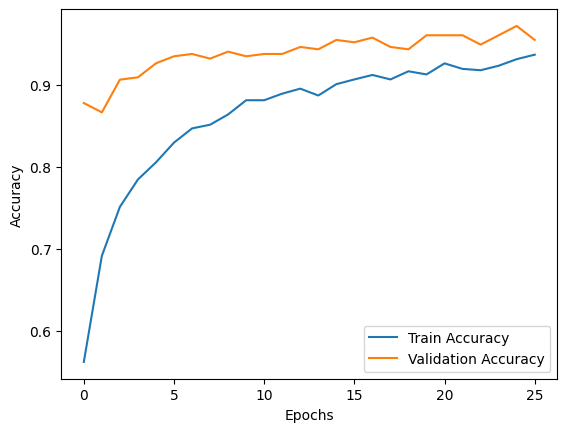

In [40]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The resulting graph seems adequate for a dataset with massive size and various features. We consider that this is enough for our prototype.

##Testing

Extracting the dataset from .zip format

In [30]:
zip_file_path = '/content/fruit-and-vegetable-image-recognition.zip'
extracted_folder_path = '/content/dataset_folder'

# Create the target directory
os.makedirs(extracted_folder_path, exist_ok=True)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

Class mapping

In [39]:
dataset_path = '/content/dataset_folder'
class_mapping = {}

for class_index, class_name in enumerate(sorted(os.listdir(dataset_path))):
    class_mapping[class_index] = class_name

print("Class Mapping:")
print(class_mapping)

Class Mapping:
{0: 'test', 1: 'train', 2: 'validation'}


In [38]:
class_mapping = training_set.class_indices

# Invert the mapping to get class names as keys and indices as values
class_mapping_inv = {v: k for k, v in class_mapping.items()}

# Print the class dictionary
print("Class Dictionary:")
print(class_mapping_inv)

Class Dictionary:
{0: 'apple', 1: 'banana', 2: 'beetroot', 3: 'bell pepper', 4: 'cabbage', 5: 'capsicum', 6: 'carrot', 7: 'cauliflower', 8: 'chilli pepper', 9: 'corn', 10: 'cucumber', 11: 'eggplant', 12: 'garlic', 13: 'ginger', 14: 'grapes', 15: 'jalepeno', 16: 'kiwi', 17: 'lemon', 18: 'lettuce', 19: 'mango', 20: 'onion', 21: 'orange', 22: 'paprika', 23: 'pear', 24: 'peas', 25: 'pineapple', 26: 'pomegranate', 27: 'potato', 28: 'raddish', 29: 'soy beans', 30: 'spinach', 31: 'sweetcorn', 32: 'sweetpotato', 33: 'tomato', 34: 'turnip', 35: 'watermelon'}


Making JSON file of class mapping dictionary

In [40]:
# Manually define class mapping
class_mapping = {
    0: 'apple',
    1: 'banana',
    2: 'orange',
    3: 'bell pepper',
    4: 'cabbage',
    5: 'capsicum',
    6: 'carrot',
    7: 'cauliflower',
    8: 'chili pepper',
    9: 'corn',
    10: 'cucumber',
    11: 'eggplant',
    12: 'garlic',
    13: 'ginger',
    14: 'grapes',
    15: 'jalepeno',
    16: 'kiwi',
    17: 'lemon',
    18: 'lettuce',
    19: 'mango',
    20: 'onion',
    21: 'orange',
    22: 'paprika',
    23: 'pear',
    24: 'peas',
    25: 'pineapple',
    26: 'pomegranate',
    27: 'potato',
    28: 'raddish',
    29: 'soy beans',
    30: 'spinach',
    31: 'sweetcorn',
    32: 'sweetpotato',
    33: 'tomato',
    34: 'turnip',
    35: 'watermelon'
}

class_mapping_file = 'class_mapping.json'
with open(class_mapping_file, 'w') as json_file:
    json.dump(class_mapping, json_file)

print(f'Class mapping saved to {class_mapping}')

Class mapping saved to {0: 'apple', 1: 'banana', 2: 'orange', 3: 'bell pepper', 4: 'cabbage', 5: 'capsicum', 6: 'carrot', 7: 'cauliflower', 8: 'chili pepper', 9: 'corn', 10: 'cucumber', 11: 'eggplant', 12: 'garlic', 13: 'ginger', 14: 'grapes', 15: 'jalepeno', 16: 'kiwi', 17: 'lemon', 18: 'lettuce', 19: 'mango', 20: 'onion', 21: 'orange', 22: 'paprika', 23: 'pear', 24: 'peas', 25: 'pineapple', 26: 'pomegranate', 27: 'potato', 28: 'raddish', 29: 'soy beans', 30: 'spinach', 31: 'sweetcorn', 32: 'sweetpotato', 33: 'tomato', 34: 'turnip', 35: 'watermelon'}


Load the model, class mapping json, and image to be tested

In [49]:
json_path = '/content/class_mapping.json'
with open(json_path, 'r') as json_file:
    class_mapping = json.load(json_file)

# Load the image classification model
model_path = '/content/fruit_veg_classifier.h5'
image_model = load_model(model_path)

def predict_image_label(image_path, model, class_mapping):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array /= 255.0

    # Predict the class probabilities
    predictions = model.predict(img_array)

    # Get the predicted class index
    predicted_class_index = tf.argmax(predictions[0]).numpy()

    # Map the class index to the label using the class mapping
    predicted_label = class_mapping[str(predicted_class_index)]

    return predicted_label

# Replace 'path/to/your/image.jpg' with the actual path to your image
image_path = '/content/semangka 2.jpg'
predicted_label = predict_image_label(image_path, image_model, class_mapping)

print(f'The predicted label is: {predicted_label}')

1/1 [==============================] - 2s 2s/step
The predicted label is: watermelon


#Returning Nutrition Facts

##Making the Function

First we make the function to classify the predicted image and return the class name.

In [59]:
def classify_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    predictions = model.predict(img_array)
    decoded_predictions = decode_predictions(predictions, top=1)[0]
    class_name = decoded_predictions[0][1].lower()
    return class_name

##Load the CSV Data

In [60]:
nutrition_data = pd.read_csv('/content/nutrition_facts.csv')

##Nutrition Lookup

In [61]:
nutrition_lookup = {}
for index, row in nutrition_data.iterrows():
    class_name = row['Item']
    translation = row['Bahan']
    nutrition_facts = {
        'Energi (kkal)': row['Energi (kkal)'],
        'Karbohidrat': row['Karbohidrat'],
        'Lemak': row['Lemak'],
        'Protein': row['Protein'],
        'Serat': row['Serat'],
        'Air (%)': row['Air (%)'],
        'Kalsium (mg)': row['Kalsium (mg)'],
        'Fosfor (mg)': row['Fosfor (mg)'],
    }
    nutrition_lookup[class_name] = {'translation': translation, 'nutrition_facts': nutrition_facts}

##Function of Predicted Class then Print the Nutrition Facts

In [62]:
def predict_and_print_nutrition(img_path):
    predicted_class = classify_image(img_path)

    # Retrieve nutrition facts based on the predicted class
    if predicted_class in nutrition_lookup:
        entry = nutrition_lookup[predicted_class]
        translation = entry['translation']
        nutrition_facts = entry['nutrition_facts']

        print(f'Predicted Class: {predicted_class} ({translation})')
        print('Nutrition Facts:')
        for nutrient, value in nutrition_facts.items():
            print(f'{nutrient}: {value}')
    else:
        print('Nutrition facts not available for the predicted class.')

##Save into JSON format

In [63]:
nutrition_json = json.dumps(nutrition_lookup, indent=4)

# Save the JSON string to a file
with open('nutrition_lookup.json', 'w') as json_file:
    json_file.write(nutrition_json)

##Adjustments For Mobile App Execution

Reference for MD

In [ ]:
from tensorflow.keras.models import load_model

# Load the image classification model
image_model = load_model("fruit_veg_classifier.h5")

# Load the nutritional facts integration model
nutrition_integration_model = load_model("nutrition_integration_model.h5")

# Pseudo-code for capturing an image using the device's camera
captured_image = capture_image_from_camera()

# Process the captured image using the image classification model
predicted_class = predict_image_class(image_model, captured_image)

# Process the predicted class using the nutritional facts integration model
nutrition_facts = get_nutrition_facts(nutrition_integration_model, predicted_class)

# Display or use the nutritional facts in your application
display_nutrition_facts(nutrition_facts)


##Testing

In [67]:
# Load the image classification model
image_model = load_model("fruit_veg_classifier.h5")

# Load the nutrition lookup JSON file
with open('nutrition_lookup.json', 'r') as json_file:
    nutrition_lookup = json.load(json_file)

def predict_and_get_nutrition(image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Get the class prediction index
    predictions = image_model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])

    # Get the class name and corresponding nutrition facts
    class_mapping = list(nutrition_lookup.keys())[predicted_class_index]
    class_name = nutrition_lookup[class_mapping]['translation']
    nutrition_facts = nutrition_lookup[class_mapping]['nutrition_facts']

    return class_name, nutrition_facts

# Example usage: Replace 'path/to/your/image.jpg' with the actual path to your image
image_path = '/content/bit 2.jpg'
class_name, nutrition_facts = predict_and_get_nutrition(image_path)

print(f'Predicted Class: {class_name}')
print('Nutrition Facts:')
for nutrient, value in nutrition_facts.items():
    print(f'{nutrient}: {value}')


1/1 [==============================] - 1s 1s/step
Predicted Class: Bit
Nutrition Facts:
Energi (kkal): 41
Karbohidrat: 9.6
Lemak: 0.1
Protein: 1.6
Serat: 2.6
Air (%): 87.6
Kalsium (mg): 27
Fosfor (mg): 43
